# Network Test

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from tqdm import tqdm
import torch
from torch.utils.data import TensorDataset, DataLoader

C:\Users\qraus\anaconda3\envs\deep_learning\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
sst = xr.open_dataset('./data/sst.nc', decode_times=False)
sst_t = torch.tensor(sst['temp'].values, dtype = torch.float32)

In [2]:
sst = xr.open_dataset("./data/sst.nc",decode_times=False)
sst_t = torch.tensor(sst.temp.values,dtype=torch.float32)

In [4]:
# load the data
with np.load('./data/enso_and_pca.npz') as data:    
    enso_index = data['y']  # 3-month-moving-averaged Nino3.4 index
    t_enso = data['t']  # months since jan. 1 1960 for the center of each 3-month window

In [3]:
# load the data
with np.load('./data/enso_and_pca.npz') as data:    
    enso_index = data['y']  # 3-month-moving-averaged Nino3.4 index
    t_enso = data['t']  # months since jan. 1 1960 for the center of each 3-month window

In [8]:
y = torch.tensor(enso_index[1:])
x = torch.tensor(sst_t[:1232])

x_norm = (x-torch.mean(x))/torch.std(x)
y_norm = (y-torch.mean(y))/torch.std(y)

x_norm1 = torch.unsqueeze(x_norm,1)

y_norm1 = torch.unsqueeze(y_norm,1)

C:\Users\qraus\AppData\Local\Temp\ipykernel_3956\3798902411.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(sst_t[:1232])


In [4]:
x = sst_t[:-4]
y = torch.tensor(enso_index[1:],dtype=torch.float32)

x_norm = (x - torch.mean(x)) / torch.std(x)
y_norm = (y - torch.mean(y))/ torch.std(y)

x_norm1 = torch.unsqueeze(x_norm,1)
print(x_norm1.shape)
y_norm1 = torch.unsqueeze(y_norm,1)
print(y_norm1.shape)

torch.Size([1232, 1, 23, 72])
torch.Size([1232, 1])


In [15]:
dataset = TensorDataset(x_norm1, y_norm1)  
# create a dataloader 
data_loader = DataLoader(dataset, batch_size=10, shuffle=True)


In [10]:
dataset = TensorDataset(x_norm1, y_norm1)  # combine the inputs and outputs into a PyTorch Dataset object
# create a dataloader to serve up batches of 400 data point for training
data_loader = DataLoader(dataset, batch_size=400, shuffle=True)

In [10]:
# build the convnet from the paper
class ConvNet(torch.nn.Module):
    def __init__(self, input_channels=1, hidden_channels=30, hidden_units=30, n_outputs=1):
        super(ConvNet, self).__init__()

        self.first_conv = torch.nn.Conv2d(input_channels, hidden_channels, (4,8), padding ='same')
        self.second_conv = torch.nn.Conv2d(hidden_channels, hidden_channels, (4,2), padding = 'same')
        self.third_conv = torch.nn.Conv2d(hidden_channels, hidden_channels, (4,2), padding='same')
        self.first_maxpool = torch.nn.MaxPool2d((2,2))
        self.second_maxpool = torch.nn.MaxPool2d((2,2))
        self.first_FC = torch.nn.Linear(30*5*18, hidden_units)
        self.second_FC = torch.nn.Linear(hidden_units, n_outputs)

    def forward(self, x):
        x = self.first_conv(x)
        x = torch.tanh(x)
        x = self.first_maxpool(x)
        x = self.second_conv(x)
        x = torch.tanh(x)
        x = self.second_maxpool(x)
        x = self.third_conv(x)
        x = torch.tanh(x)
        x = x.reshape(-1,30*5*18)
        x = self.first_FC(x)
        x = torch.tanh(x)
        x = self.second_FC(x)

        return x

In [6]:
# build the convnet from the paper
class ConvNet(torch.nn.Module):
    def __init__(self, input_channels=1, hidden_channels=30, hidden_units=30, n_outputs=1):
        super(ConvNet, self).__init__()

        self.first_conv   = torch.nn.Conv2d(input_channels,hidden_channels,(4,8),padding='same')
        self.first_pool   = torch.nn.MaxPool2d((2,2))
        self.second_conv  = torch.nn.Conv2d(hidden_channels,hidden_channels,(2,4),padding='same')
        self.second_pool   = torch.nn.MaxPool2d((2,2))
        self.third_conv  = torch.nn.Conv2d(hidden_channels,hidden_channels,(2,4),padding='same')
        self.first_FC     = torch.nn.Linear(hidden_channels * 5 * 18, hidden_units)
        self.second_FC    = torch.nn.Linear(hidden_units, n_outputs)
        
    def forward(self, x):
        x = self.first_conv(x)
        x = torch.tanh(x)
        x = self.first_pool(x)
        x = self.second_conv(x)
        x = torch.tanh(x)
        x = self.second_pool(x)
        x = self.third_conv(x)
        x = torch.tanh(x)
        x = x.reshape(-1,30 * 5 * 18)
        x = self.first_FC(x)
        x = torch.tanh(x)
        x = self.second_FC(x)

        return x

In [16]:
conv = ConvNet()
n_epochs = 50
learning_rate = 0.01

lossfunc = torch.nn.MSELoss()
optimizer = torch.optim.SGD(conv.parameters(), lr=learning_rate)

Loss = []

for epoch in tqdm(range(n_epochs)):
    for batch_index, batch in enumerate(data_loader):
        # note that each time this loop is run through, the order of the data is randomly permuted!
        x_batch, y_batch = batch
        optimizer.zero_grad()
        yhat_batch = conv(x_batch)
        loss = lossfunc(yhat_batch, y_batch)
        Loss = np.append(Loss, loss.detach().numpy())        
        loss.backward()
        torch.no_grad()
        optimizer.step()  # this will update parameters using torch.no_grad(), then zero the gradients for us


100%|██████████████████████████████████████████████████████████████████████████████████| 50/50 [01:47<00:00,  2.16s/it]


In [11]:
conv = ConvNet()
n_epochs = 100
learning_rate = 0.01  # adjust this if necessary

lossfunc = torch.nn.MSELoss()
optimizer = torch.optim.SGD(conv.parameters(), lr=learning_rate)
Loss     = []

for epoch in tqdm(range(n_epochs)):
    for batch_index, batch in enumerate(data_loader):
        # note that each time this loop is run through, the order of the data is randomly permuted!
        x_batch, y_batch = batch
        optimizer.zero_grad()

        yhat_batch = conv(x_batch)
        loss = lossfunc(y_batch,yhat_batch)
        Loss.append(loss.detach().numpy())
        
        loss.backward()
        torch.no_grad()
        optimizer.step()  # this will update parameters using torch.no_grad()
        #optimzer.zero_grad()

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [02:34<00:00,  1.54s/it]


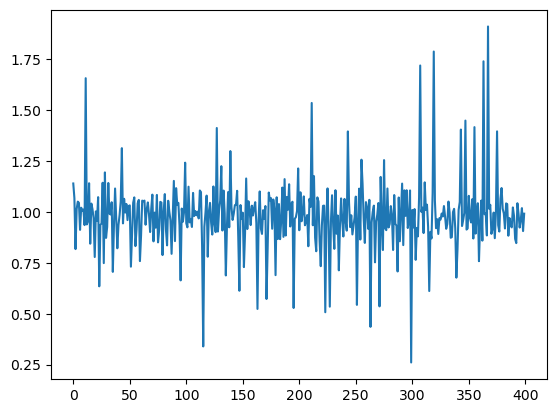

In [12]:
plt.plot(Loss)

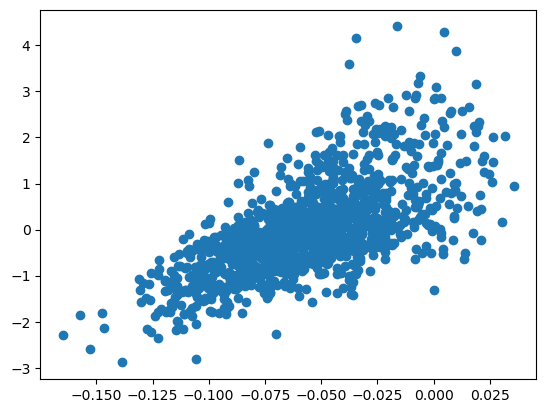

In [13]:
plt.scatter(conv(x_norm1).detach().numpy(),y_norm1.detach().numpy())